# CVA Calculation for an Interest Rate Swap

In this report we do following:
1. Describe how to calculate the credit valuation adjustment taken by Counterpart A to the price of an interest rate swap using credit spreads for Counterparty B. 
2. Plot MtM values and produce :
    * A smoothed Expected Exposure profile. While EE is defined as Max($MtM_{\tau}$, 0), we experiment with exposure distributions(s) at each tenor. Produce smoothed Potential Future Exposure(s) using such indicators as

    * The median of positive exposure
    
    * 97.5th percentile

#### Input for IRS Valuations are :

1. Forward LIBORs
2. Discounting Factors (DF)
3. Default probabilities (PDs)

Assumptions
* The IRS is assumed to be written on a 6M LIBOR $L_{6M}$ expiring in 5Y, hence the payment frequency is $\tau=0.5$
* The notional is assumed to be $N=1$
* Recovery rate 40%

 ### Default Probabilities (PDs)

Default Probabilities are calculated from CDS spreads using the bootstrapping in excel 'PD CDS Bootstrapping.xlsx.'

In [11]:
from matplotlib.ticker import FuncFormatter

import pandas as pd
import numpy as np
import math
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab


data2 = pd.read_csv("CVAInput.csv", index_col=0)
output = data2.to_string(formatters={'Lambda': '{:,.4%}'.format, 'PD': '{:,.4%}'.format,'P': '{:,.4%}'.format})
print(output)

           CDS        DF  Lambda       PD         P
Tenor                                              
0.0        NaN  1.000000    nan%  0.0000% 100.0000%
0.5    128.400  0.995835 2.1286%  1.0587%  98.9413%
1.0    150.000  0.990963 2.2197%  2.1953%  97.8047%
1.5    200.295  0.985697 2.7798%  4.0839%  95.9161%
2.0    250.590  0.980105 3.3452%  6.4715%  93.5285%
2.5    280.295  0.974101 3.9174%  9.3293%  90.6707%
3.0    310.000  0.967832 4.4994% 12.6268%  87.3732%
3.5    360.000  0.961232 5.0170% 16.1043%  83.8957%
4.0    410.000  0.954239 5.5471% 19.8991%  80.1009%
4.5    500.000  0.946899 6.0576% 23.8595%  76.1405%
5.0    590.000  0.939187 6.5842% 28.0510%  71.9490%


## Forward LIBORs


* LIBOR  indicates money-market rates for actual loans between banks for upto 18 M

* OIS targets the Federal Funds Rate, an average over the period. The spread for LIBOR fixings Vs OIS prices reveals the short-term credit risk in the financial system.

#### OIS Discount factors

* Observe the difference between DF taken under the forward measure and $DF_{OIS}$ representing the risk-neutral measure Q.

Used Bank of England data for Forward Curve from BOE website http://www.bankofengland.co.uk and used 5 year data from Tab '1. fwds, short end' rest 20 years from Tab '2. fwd curve' from sheet ukblc05_mdaily.xlsx and ukblc16_mdaily.xlsx. Data sampled from 13th Sep 2015 till 20th July 2017 and kept in sheet HJM Model MC.xlsm Tab 'FwdCurve'

Following step was taken to find eigen values using Principal Components Analysis:
1. Calculated difference of Forward Curve data in Tab 'FwdCurve' and kept in Tab 'Difference'
2. Calculated Covariance of Difference in Tab 'Difference' and kept it in Tab 'Covariance'
3. Calculated Eigenvalues based on 'Covariance' Tab and kept in PCFV tab.
4. Calculated EigenVectors using Jacobi algorithm.
5. Sorted Eigenvalues and found the top 3 eigen values.

|             | Tenor | Eigenvalue | Cum. R^2 |
|-------------|-------|------------|----------|
| 1st largest PC| 7.0	| 0.002370368 |	8.98E-01 |
| 2nd largest PC| 2.0	| 0.000121736 | 9.45E-01 |
| 3rd largest PC| 25.0 | 7.71771E-05 | 9.738E-01 |

* Selected Principal Components as top 3 eigen values and calucated Principal Components volatility functions as below in Tab 'Volatility', 'Vol_1', 'Vol_2', 'Vol_3':
$$
Vol_i = \sqrt{\lambda_i} \space e(i) \space\space\space \forall \space i=1,2,3
$$
a

In [12]:
from IPython.display import IFrame
IFrame("PCA_Chart.pdf", width=600, height=450)

The drift function $\mu(t)$ is obtained by integrating over the principal components and assuming that volatility is a function of time. Refer Tab 'MC'

Volatility and Drift functions are used in HJM model Monte Carlo simulation to produce forward curve using below equations:

$$
d\bar{f} = \mu (t) dt + \sum_{i=1}^{3} Vol_i \phi_i \sqrt{dt} + \frac{dF}{d\tau} dt
$$

where $\phi_i$ is a random number drawn from the standard normal distribution and the last term is the Musiela correction. 


In [24]:
from IPython.display import IFrame
IFrame("Vol_1.pdf", width=500, height=400)

In [25]:
from IPython.display import IFrame
IFrame("Vol_2.pdf", width=500, height=400)

In [26]:
from IPython.display import IFrame
IFrame("Vol_3.pdf", width=500, height=400)

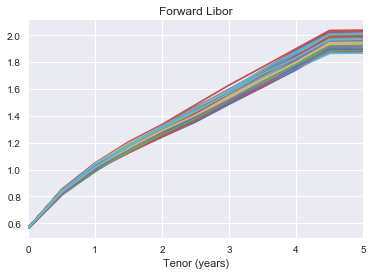

In [28]:
from __future__ import division
import numpy as np
import pandas as pd
import math

M = 451
I = 451
n_tau = 50 
dt = 0.01
shape_3D = (M + 1, I, n_tau + 1)
np.random.seed(1000)

data = pd.read_csv("CVAParams.csv", index_col=0)
mu = np.array(data.iloc[0, :], dtype=np.float)
vol1 = np.array(data.iloc[1, :], dtype=np.float)
vol2 = np.array(data.iloc[2, :], dtype=np.float)
vol3 = np.array(data.iloc[3, :], dtype=np.float)
S0 = np.array(data.iloc[4, :], dtype=np.float)
#print(data.columns)
tau = np.array(data.columns, dtype=np.float)
d_S_plus = np.diff(S0)
d_S_plus = np.append(d_S_plus, d_S_plus[-1])
d_tau = np.diff(tau)
d_tau = np.append(d_tau, d_tau[-1])


t_m = np.zeros((M + 1), dtype=np.float)
S_plus_m = np.zeros(shape_3D, dtype=np.float)

t_m[0] = 0.0
S_plus_m[0][:] = S0
S_minus_m = S_plus_m.copy()  

for i in range(1, M + 1):
    #if i % 10 == 0:
        #print ('i=%d' % i)

    rand1 = np.random.standard_normal((I, 1))
    rand2 = np.random.standard_normal((I, 1))
    rand3 = np.random.standard_normal((I, 1))

    d_S_plus = np.diff(S_plus_m[i-1][:])
    d_S_plus = np.hstack((d_S_plus, d_S_plus[:, -1].reshape(I, 1)))
    d_S_minus = np.diff(S_minus_m[i-1][:])
    d_S_minus = np.hstack((d_S_minus, d_S_minus[:, -1].reshape(I, 1)))

    t_m[i] = round(t_m[i - 1] + dt,2)
    S_plus_m[i][:] = S_plus_m[i - 1][:] + mu * dt + (vol1 * rand1 + vol2 * rand2 + vol3 * rand3) * math.sqrt(dt) + (d_S_plus / d_tau) * dt
    S_minus_m[i][:] = S_minus_m[i - 1][:] + mu * dt + (vol1 * (-rand1) + vol2 * (-rand2) + vol3 * (-rand3)) * math.sqrt(dt) + (d_S_minus / d_tau) * dt

data2 = pd.read_csv("CVAInput.csv", index_col=0)

col_names = ['Sim' + str(x) for x in range(1, I + 1)]
f_plus = pd.DataFrame(index=data2.index, columns=col_names, dtype=np.float) 
i = 0

for index, row in f_plus.iterrows():
    f_plus.loc[index, :] = S_plus_m[int(i), :, 1]
    i += 50
    if i>S_plus_m.shape[0]:
        i=S_plus_m.shape[0]-1

freq = 0.5
L_plus = (1.0 / freq) * (np.exp(f_plus * freq) - 1.0)
K_plus = L_plus.iloc[0, :][0]
L_plus_masked = np.ma.masked_where(L_plus < K_plus, L_plus)

L_plus.iloc[:, 0:450].plot(title='Forward Libor')
_ = plt.xlabel('Tenor (years)')
_ = plt.legend('')  # remove legend

## Discount Factors

DF is calculated as below:

$$
DF(0, T_{i+1}) = \prod_{i} \frac{1}{1 + \tau_i L(t; T_i, T_{i+1})} 
$$

In [5]:
ZCB_plus = 1.0 / (1 + freq * L_plus)
ZCB_plus.iloc[0, :] = 1.0 
ZCB_plus = ZCB_plus.cumprod()
ZCB_plus_mean = pd.Series(index=ZCB_plus.index, data=np.mean(ZCB_plus, axis=1))

DF = pd.DataFrame(index=ZCB_plus.index, columns=list(ZCB_plus.index))
DF.loc[0.0, :] = ZCB_plus_mean


for index, row in DF.iterrows():
    if index == 0.0:
        continue
    x = DF.loc[0.0][row.index]/DF.loc[0.0, index]
    x[x > 1] = 0
    DF.loc[index, :] = x
    
DF2 = DF.copy()
np.fill_diagonal(DF2.values, 1)
DF2

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
Tenor,,,,,,,,,,,
0.0,1,0.706845,0.468495,0.296335,0.180174,0.105497,0.0595304,0.032374,0.0169816,0.00860365,0.00435629
0.5,0,1,0.662798,0.419237,0.254898,0.14925,0.0842199,0.0458008,0.0240245,0.0121719,0.006163
1.0,0,0,1,0.632526,0.38458,0.225182,0.127067,0.0691022,0.0362472,0.0183644,0.00929847
1.5,0,0,0,1,0.608006,0.356004,0.200889,0.109248,0.0573054,0.0290335,0.0147005
2.0,0,0,0,0,1,0.585527,0.330406,0.179682,0.0942514,0.047752,0.0241783
2.5,0,0,0,0,0,1,0.564288,0.306873,0.160968,0.0815538,0.0412932
3.0,0,0,0,0,0,0,1,0.543823,0.285259,0.144525,0.0731775
3.5,0,0,0,0,0,0,0,1,0.524544,0.265758,0.134561
4.0,0,0,0,0,0,0,0,0,1,0.506645,0.25653


## CVA

#### MtM 

HJM output (simulated inst / discreate forwards rates) gives more flexibility in building the Exposure Profile:
simulation deliver a sample of same period rates from which the median and 97.5, 99th percentile rates can be picked for PFE.

MtM values are (discounted) swap cashflows form the initial curve $|->$ [0, 5Y], then the curve of the Forward LIBORs $|->$ [0, 4.5] simulated at t= 0.5, then $|->$ [0, 4] simulated at t=1.

HJM output is in rows: at each reset point use the shorter curve:
t=1 the cureve is over [0, 4Y]

While Fwd LIBOR are taken off the curve, the range of curve movements generated by the HJM potentially allows using tenor column $\tau$ = 0.5 only. Credit risk on the swap payment is maximum 6M.

$
MtM_{3Y} = \sum^{T=5}_{i=3} D.F. (L - K) PD
$


where $N$ is the notional and $K$ the fixed agreed rate and $L_i = L(t; T_{i-1}, T_{i})$.



### Exposure


The exposure for each tenor $E_i$ is calculated from the positive part of the MTM simulations as:
$$
E_i = max(V_i, 0)
$$


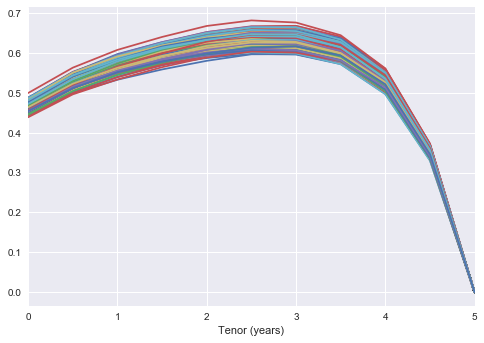

In [6]:
np.fill_diagonal(DF.values, 0)
N = 1.0
V_plus = N * freq * DF.dot(L_plus - K_plus)
E_plus = np.maximum(V_plus, 0)

E_plus2 = np.array(E_plus, dtype=np.float32)
E_plus_masked = np.ma.masked_where(E_plus2 == 0, E_plus2)


E_plus.loc[:, E_plus.loc[0.5] > 0].plot().plot(title='Exposure Profiles')
_ = plt.xlabel('Tenor (years)')
_ = plt.legend('')  # remove legend

#### Expected Exposure
The Expected Exposure (EE) is calculated as the median of the Exposure profile.


In [7]:

EE_plus_median = pd.Series(index=E_plus.index[:-1], data=np.ma.median(E_plus_masked[:-1], axis=1))
EE_plus_median.loc[5.0] = 0.0
EE_plus_mean = pd.Series(index=E_plus.index[:-1], data=np.ma.mean(E_plus_masked[:-1], axis=1))
EE_plus_mean.loc[5.0] = 0.0

PFE_plus = pd.Series(index=E_plus.index, data=np.percentile(E_plus_masked, q=97.5, axis=1))

index_interpol = ['0.0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0']

EE_plus_median_interpol = (EE_plus_median + EE_plus_median.shift(-1)) / 2.0
EE_plus_median_interpol = EE_plus_median_interpol.iloc[:-1]
EE_plus_median_interpol.index = index_interpol

DF_interpol = DF.loc[0.0, :].copy()
DF_interpol[0.0] = 1.0
DF_interpol = (DF_interpol + DF_interpol.shift(-1))/2.0
DF_interpol = DF_interpol.iloc[:-1]
DF_interpol.index = index_interpol

PD_interpol = data2['PD'].iloc[1:]
PD_interpol.index = index_interpol


print (np.max(EE_plus_median)*100.0)
print (np.max(PFE_plus)*100.0)

63.209182024
65.8002451062


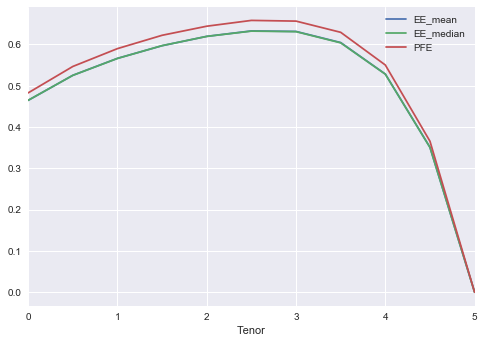

In [8]:
EE_plus_mean.plot(label="EE_mean")
EE_plus_median.plot(label="EE_median")
PFE_plus.plot(label="PFE")
plt.legend()

### CVA

CVA is approximated by a linear interpolation across the tenors:

$$
CVA \approx \sum_i (1-R)E(\frac{T_{i-1}-T_i}{2}) DF(\frac{T_{i-1}-T_i}{2}) PD(\frac{T_{i-1}-T_i}{2})
$$



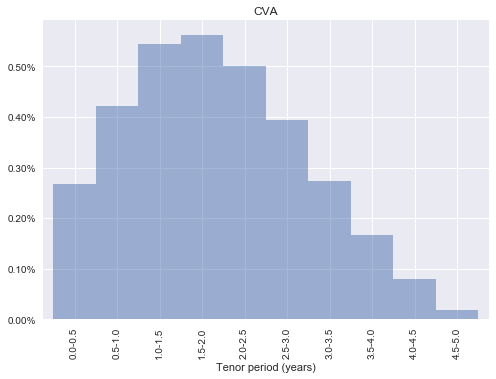

In [9]:
RR = 0.4
CVA = (1 - RR) * EE_plus_median_interpol * DF_interpol * PD_interpol
CVA_total = CVA.sum()

ax =CVA.plot.bar(width=1.0, alpha=0.5, title='CVA')
_ = plt.xlabel('Tenor period (years)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

In [10]:
print (CVA_total*100)

3.233191853001126
